# HW3: Sensing & Coordinate Frames

## EECE 5550: Mobile Robotics (Spring 2025)

**Collaboration Statement:**

In [1]:
# Fill this in per the syllabus, or we will assign a zero to this assignment.
# I completed the assignment myelf.

# Installation

This semester, we will use a custom simulator, called `gym-neu-racing`, to develop navigation algorithms. We implemented the basic structure of this simulator for you, and the HW assignments will ask you to implement important functions (e.g., kinematics, sensing, planning, mapping).

To install the simulator, you can use this command (it will download the latest code from GitLab and automatically install it in the environment your Colab notebook runs in):

In [2]:
!pip install git+https://gitlab.com/neu-autonomy/gym-neu-racing.git

  Cloning https://gitlab.com/neu-autonomy/gym-neu-racing.git to /private/var/folders/wc/08xknhgs0_5db8mm26d06rhr0000gn/T/pip-req-build-xi1pzayj
  Running command git clone --filter=blob:none --quiet https://gitlab.com/neu-autonomy/gym-neu-racing.git /private/var/folders/wc/08xknhgs0_5db8mm26d06rhr0000gn/T/pip-req-build-xi1pzayj
  Resolved https://gitlab.com/neu-autonomy/gym-neu-racing.git to commit b8aed82115801ab8818631013eb8672becd56ead
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


Now that the simulator and its dependencies have been installed, you can import the modules you'll need for this assignment:

In [3]:
import gymnasium
import numpy as np
import gym_neu_racing
from gymnasium import spaces
from gym_neu_racing.envs.wrappers import StateFeedbackWrapper
import matplotlib.pyplot as plt
from typing import Callable
import matplotlib.cm as cmx
import matplotlib.colors as colors
from gym_neu_racing import motion_models
from gym_neu_racing import sensor_models
import cvxpy as cp
from gym_neu_racing.sensor_models.sensor_model import SensorModel

You can create an instance of the simulator that you'll build on throughout the assignment:

# Problem 1: Lidar Sensor Model

## 1a) 2D Lidar Simulation

In previous assignments, we gave you the robot's true state and environment map. However, in many real robotics settings, onboard sensors are the only way to estimate the robot's state and what the environment looks like.
Therefore, in this problem, you'll implement a basic version of a 2D Lidar simulator that we'll use as input to our estimation algorithms on in future assignments.

We will use the idea of *ray tracing* for this sensor model.
A rough sketch for this is: for each beam, check whether the map is free or occupied as you move along the beam away from the robot's current position (if it's free, keep moving further along the range (increment by `self.range_resolution`); if it's occupied, stop there, and you now have the distance to the first occupied cell along that beam). After you've done this for all beams, you can return an array of angles and a corresponding array of ranges - that's the data format used by most Lidar sensors when reporting measurements. Lastly, if there are no obstacles within the maximum range (`range_limits[1]` meters), you should return `np.inf` for that beam, per [ROS REP 117](https://www.ros.org/reps/rep-0117.html).

It may be helpful to implement this sensor model with a few for loops that iterate over each beam and increment range resolution until finding an occupied cell, but this will probably be pretty slow computationally. Instead of nested for loops, you could leverage numpy operations (e.g., `np.where`, `np.cumsum`, `np.logical_and`, `np.meshgrid`, `np.tile`) to efficiently make these calculations over all beams and ranges. You're also of course welcome to try using JAX and its `vmap` operator if you feel inspired...

We also provide a simple plotting function in case that helps you debug your sensor model implementation.

For this model, we'll assume:
* the lidar senses free/occupied space ideally (i.e., zero probability of spurious readings)
* the robot has zero radius (i.e., the sensor will not have any ``self-hits'' where the beam hits a point on the robot and returns a short range)
* the robot's body frame (in which `current_state` and `obs["state"]` are reported) and lidar frame (in which the lidar data is reported) are aligned (i.e., the transformation matrix between these two frames is the identity matrix)

**Deliverables**:
- Implement the `Lidar2D` class, in particular the `step` method, so that the returned `sensor_data` contains the correct `angles` and corresponding `ranges` in the lidar's frame, based on the environment map and the robot's `current_state` (be sure to account for position and orientation of the robot!).
- Print the first `sensor_data` your Lidar2D sensor returns from the `env.reset()` method
- Include a plot that shows the environment map with your first lidar scan overlayed on top

In [4]:
# Create an instance of the mobile robot simulator we'll use this semester
env = gymnasium.make("gym_neu_racing/NEURacing-v0")

In [5]:
class Lidar2D(SensorModel):
    """2D LaserScan based on map of the environment

    :param num_beams: (int) how many beams/rays should be in the laserscan
    :param range_resolution: (float) distance to increment along each beam
                                (meters)
    :param range_limits: (np.array) min, max range per beam (meters)
    :param angle_limits: (np.array) angle of first and last beam, relative to
                                    agent's current heading (radians)
    """

    def __init__(
        self,
        static_map,
        num_beams=16,
        range_resolution=0.1,
        range_limits=np.array([0, 6]),
        angle_limits=np.array([-np.pi / 2, np.pi / 2]),
    ):
        super().__init__()
        self.static_map = static_map
        self.num_beams = num_beams
        self.range_resolution = range_resolution
        self.range_limits = range_limits
        self.angle_limits = angle_limits

        # You should use this array as the angle of each beam in your sensor model
        self.angles = np.linspace(
            self.angle_limits[0], self.angle_limits[1], self.num_beams
        )

        # You should use this array to check for occupied cells along each beam
        self.ranges = np.arange(
            self.range_limits[0], self.range_limits[1], self.range_resolution
        )

        self.observation_space = spaces.Dict(
            {
                "angles": spaces.Box(
                    -np.pi, np.pi, shape=(self.num_beams,), dtype=float
                ),
                "ranges": spaces.Box(
                    self.range_limits[0],
                    np.inf,
                    shape=(self.num_beams,),
                    dtype=float,
                ),
            }
        )

    def step(self, current_state: np.ndarray) -> dict:
        """Use top-down map to ray-trace for obstacles."""

        """Your implementation here."""
        # raise NotImplementedError
        ranges = np.zeros_like(self.angles)
        x0, y0, theta = current_state
        i = 0
        for i, angle in enumerate(self.angles):
            prev_val = 0
            angle = theta + angle
            for j, value in enumerate(self.ranges):
                x, y = value * np.cos(angle), value * np.sin(angle)
                x = x0 + x
                y = y0 + y
                current_state = np.array([x, y])
                map_indices = self.static_map.world_coordinates_to_map_indices(current_state)
                map_indices = self.static_map.world_coordinates_to_map_indices(current_state)
                occupancy = self.static_map.static_map[map_indices[0][0], map_indices[0][1]]
                if occupancy:
                    ranges[i] = value
                    break
                elif j == len(self.ranges) - 1:
                    ranges[i] = np.inf
                    break

        # angles, ranges reported in sensor frame
        sensor_data = {
            "ranges": ranges,
            "angles": self.angles,
        }

        return sensor_data

In [6]:
def plot_lidar_measurements(static_map, obs: dict) -> None:
    """Transform lidar readings into world frame and overlay on static map."""

    # Use angles/ranges to get the (x, y) coordinates in the lidar frame, but
    # skip any pts where the range = np.inf
    ranges = obs["lidar"]["ranges"]
    non_max_range_inds = np.where(ranges < np.inf)
    ranges = ranges[non_max_range_inds]
    angles = obs["lidar"]["angles"][non_max_range_inds]
    hit_pts_in_lidar_frame = np.stack(
        [ranges * np.cos(angles), ranges * np.sin(angles)]
    ).T

    # Build the lidar-to-world TF matrix using the robot's current position, heading
    x, y, theta = obs["state"]
    T_world_lidar = np.array(
        [
            [np.cos(theta), -np.sin(theta), x],
            [np.sin(theta), np.cos(theta), y],
            [0, 0, 1],
        ]
    )

    # Transform the (x,y) coordinates from the lidar frame to the world frame
    hit_pts_in_lidar_frame_homogeneous = np.hstack(
        [hit_pts_in_lidar_frame, np.ones((hit_pts_in_lidar_frame.shape[0], 1))]
    )
    hit_pts_in_world_frame = np.dot(
        hit_pts_in_lidar_frame_homogeneous, T_world_lidar.T
    )

    # Overlay the lidar pts on top of the static map
    static_map.draw_map(show=False)
    for pt in hit_pts_in_world_frame:
        plt.plot([x, pt[0]], [y, pt[1]], "r-")

    # Draw the robot as a blue triangle to indicate its pose
    robot_pts = np.array([[0.4, 0.0], [0, -0.1], [0, 0.1], [0.4, 0.0]])
    robot_pts_homogeneous = np.hstack(
        [robot_pts, np.ones((robot_pts.shape[0], 1))]
    )
    robot_pts_in_world_frame = np.dot(robot_pts_homogeneous, T_world_lidar.T)
    plt.plot(
        robot_pts_in_world_frame[:, 0], robot_pts_in_world_frame[:, 1], "b-"
    )

    plt.show()

You can use the following code to see what your sensor returns in specific states:

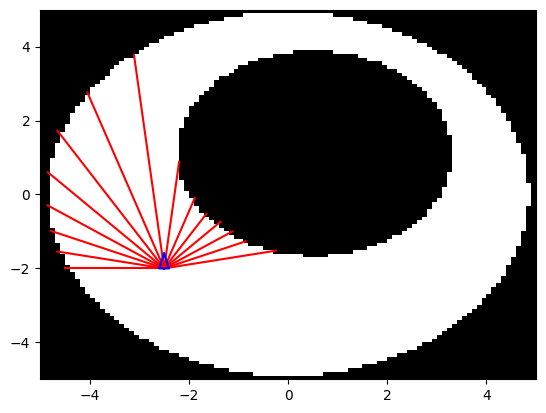

In [7]:
state = np.array([-2.5, -2, np.pi/2])
lidar_measurements = Lidar2D(env.unwrapped.map).step(state)
obs = {"state": state, "lidar": lidar_measurements}
plot_lidar_measurements(env.unwrapped.map, obs)

And for the deliverables, you should confirm your sensor also works as part of the full simulator:

{'state': array([ 0.8392881 , -3.78481063,  3.24435603]), 'lidar': {'ranges': array([2.1, 2.3, 2.8, inf, inf, inf, 5. , 4. , 3. , 2.3, 1.9, 1.6, 1.3,
       1.2, 1.1, 1.1]), 'angles': array([-1.57079633, -1.36135682, -1.15191731, -0.9424778 , -0.73303829,
       -0.52359878, -0.31415927, -0.10471976,  0.10471976,  0.31415927,
        0.52359878,  0.73303829,  0.9424778 ,  1.15191731,  1.36135682,
        1.57079633])}}


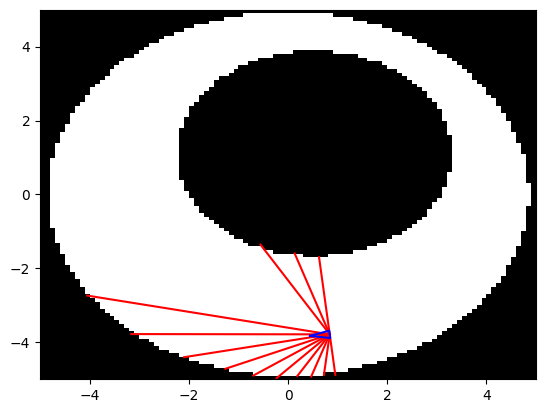

In [8]:
# Initialize the environment (and set random seed so any randomness is repeatable)
np.random.seed(0)

# Tell the environment to use your new Lidar2D sensor
env.unwrapped.sensor_models = {
  "state": sensor_models.StateFeedback(),
  "lidar": Lidar2D(env.unwrapped.map),
}

# Reset the environment and get the first observation (state + lidar)
obs, _ = env.reset()
print(obs)
plot_lidar_measurements(env.unwrapped.map, obs)

## 1b) Adding noise to your ideal 2D lidar model

In the previous part, we assumed that the lidar sensor returns the correct range (whenever there is an occupied cell within a distance less than the maximum range). In reality, lidar sensors are subject to various issues that can degrade the returned range measurements. In this part, you will extend your sensor model to include some of these effects.

In particular, your job is to implement this idea as `Lidar2DRealistic`, using a PDF that accounts for the 4 types of errors described in the following slides [Slide 1](https://northeastern.sharepoint.com/:i:/s/EECE5550Crew/Ef9xNqaeM-xIoyK-Frgp_pgByp1ZX6G2DuDPay9qwOL56g?e=stnmc0) [Slide 2](https://northeastern.sharepoint.com/:i:/s/EECE5550Crew/Ef34lEdH6gtJhq-q61cyLQEBznUrxe32AdlUr5XV5elnYw?e=nfgwfm). The slides use the following notation: $x_t$ is the robot's state at time $t$, $m$ is the map, $z_t^k$ is the $k^\text{th}$ beam's reading at time $t$, $z_t^{k*}$ is the true range that a perfect sensor would have read. Instead of returning the true range $z_t^{k*}$ for each beam $k$, we will treat each beam's reading as an i.i.d. sample from a conditional probability distribution, $P(z_t^k | x_t, m)$.

For example, we provide a simple version of this below, where $z_t^k \sim N(z_t^{k*}, \sigma^2)$.

The specifics are all up to you (weights, distribution types, magnitudes, etc). We aren't looking for an exact copy of the pictures in the slides, but rather that you account for those types of errors in your model and provide any hyperparamters in your model (e.g., variances, weights) as arguments to your `Lidar2DRealistic` class, with default values that seem reasonable to you.

**Deliverables**:
- Implement the `Lidar2DRealistic` class to incorporate the more interesting probabilistic model
- Provide 2-3 plots/figures that demonstrate that your code is working as you expect. For example, you could create a plot of the empirical distribution of one beam when the robot is stationary - but you are encouraged to think about what form of results you can generate that would help convey what you have implemented.

In [168]:
class Lidar2DGaussian(Lidar2D):
    """2D Lidar sensor with Gaussian noise added to range readings."""

    def __init__(
        self,
        static_map,
        num_beams=16,
        range_resolution=0.1,
        range_limits=np.array([0, 10]),
        angle_limits=np.array([-np.pi / 2, np.pi / 2]),
        range_variance=0.1**2,
    ):
        super().__init__(
            static_map, num_beams, range_resolution, range_limits, angle_limits
        )
        self.range_variance = range_variance
        self.range_std = np.sqrt(range_variance)

    def step(self, current_state: np.ndarray) -> dict:
        """Query Lidar2D.step, then add Gaussian noise to the ranges."""
        sensor_data = super().step(current_state)

        ranges = np.random.normal(sensor_data["ranges"], self.range_std)

        sensor_data["ranges"] = ranges

        return sensor_data

In [ ]:
class Lidar2DRealistic(Lidar2D):
    def __init__(
        self,
        static_map,
        num_beams=16,
        range_resolution=0.1,
        range_limits=np.array([0, 10]),
        angle_limits=np.array([-np.pi / 2, np.pi / 2]),
        range_variance=0.1**2,
    ):
        self.range_variance = range_variance
        self.range_std = np.sqrt(range_variance)
        super().__init__(
            static_map, num_beams, range_resolution, range_limits, angle_limits
        )
    def step(self, current_state: np.ndarray) -> dict:
        """Your implementation here..."""
        ranges = np.zeros_like(self.angles)
        x0, y0, theta = current_state
        i = 0
        for i, angle in enumerate(self.angles):
            prev_val = 0
            angle = theta + angle
            for j, value in enumerate(self.ranges):
                x, y = value * np.cos(angle), value * np.sin(angle)
                x = x0 + x
                y = y0 + y
                current_state = np.array([x, y])
                map_indices = self.static_map.world_coordinates_to_map_indices(current_state)
                map_indices = self.static_map.world_coordinates_to_map_indices(current_state)
                occupancy = self.static_map.static_map[map_indices[0][0], map_indices[0][1]]
                if occupancy:
                    ranges[i] = value
                    break
                elif j == len(self.ranges) - 1:
                    ranges[i] = np.inf
                    break
        
        # Noisy Distribution
        ranges_guass = np.random.normal(ranges, self.range_std)
        # Transient Objects
        # ranges_short = np.random.normal(ranges, self.range_std)
        ranges_short = np.where(ranges < 2.5, np.random.exponential(scale=1.0), ranges)
        # Failure Accounting
        ranges_fail = ranges.copy()
        ranges_fail[self.range_limits[1] - ranges_fail < 0.1] = np.inf
        # Ranom or Unaccounted noises
        ranges_rand = ranges + (1 / self.range_limits[1])

        weights = np.array([0.7, 0.1, 0.1, 0.1])
        ranges_stacked = np.stack([ranges_guass, ranges_short, ranges_fail, ranges_rand])

        ranges_final = np.dot(weights, ranges_stacked)

        # angles, ranges reported in sensor frame
        sensor_data = {
            "ranges": ranges_final,
            "angles": self.angles,
        }

        return sensor_data

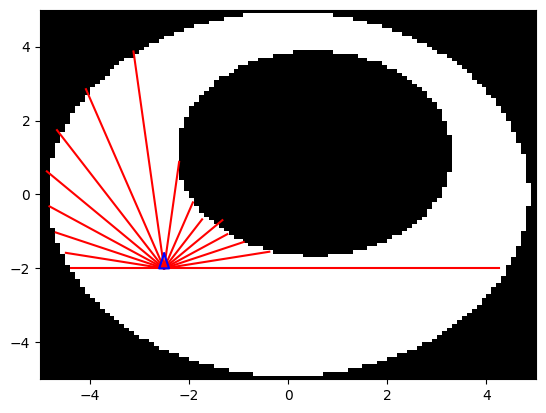

In [32]:
state = np.array([-2.5, -2, np.pi/2])
lidar_measurements = Lidar2DRealistic(env.unwrapped.map).step(state)
obs = {"state": state, "lidar": lidar_measurements}
plot_lidar_measurements(env.unwrapped.map, obs)

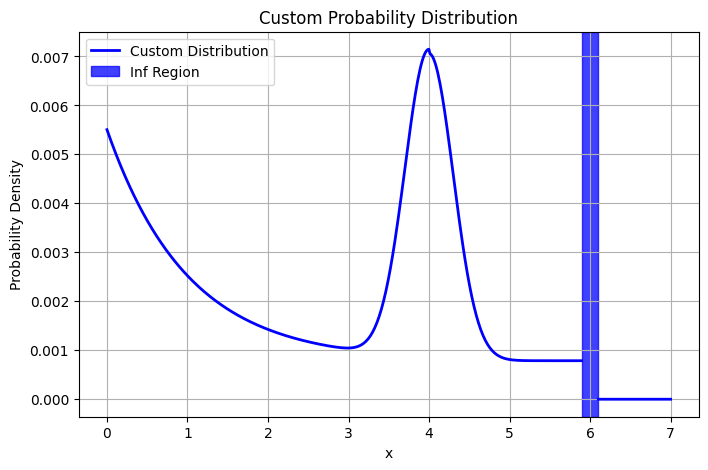

In [33]:
# Distribution plot
from scipy.stats import norm

x = np.linspace(0, 7, 500)
z_max = 6
z = 4
e = 0.1
lambda_exp = 1

exp_mask = x <= z
exp_dist = np.exp(-lambda_exp * x) * exp_mask
normal_dist = norm.pdf(x, loc=4, scale=np.sqrt(0.09))
constant_dist = 1 / z_max

distribution = exp_dist + normal_dist + constant_dist

distribution[x > z_max] = 0
inf_mask = (x >= z_max - e) & (x <= z_max + e)
distribution[inf_mask] = np.inf


finite_mask = np.isfinite(distribution)
distribution[finite_mask] /= np.sum(distribution[finite_mask])

# Plot the distribution
plt.figure(figsize=(8, 5))
plt.plot(x, distribution, label="Custom Distribution", color='b', lw=2)
plt.axvspan(z_max - e, z_max + e, color='blue', alpha=0.75, label="Inf Region")
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.title("Custom Probability Distribution")
plt.legend()
plt.grid()
plt.show()


# Problem 2: Coordinate Transformations

There are 8 pairs of coordinate frames below.
For each pair, estimate the transformation matrix, $T_{BS} \in SE(3)$ ($B$ = "big" and $S$ = "small"). We will use the convention that red = x, green = y, blue = z (RGB <-> XYZ).

You can also find a [.gif](https://northeastern.sharepoint.com/:f:/s/EECE5550Crew/ElF9gpamBx5Ph-hgX-RKkxoBZECGhaPnDAEW5_4rIy-gvQ?e=GyZm4r) for each coordinate frame pair to get better views than the static images below.

Since there are no gridlines for dimensions, you can provide your best estimate "by hand". In other words, you **shouldn't need any formulas** and it's ok if your numbers aren't exactly right. To give a rough idea of scale, the big coordinate axes are each of length 2 and the small coordinate axes are each of length 1. The rotations all use multiples of $\frac{\pi}{4}$, and the translations all use multiples of 0.5.

Finally, you should not include any scaling coefficients in your matrix (we only scaled the axes to make it clear that there were 2 different frames).

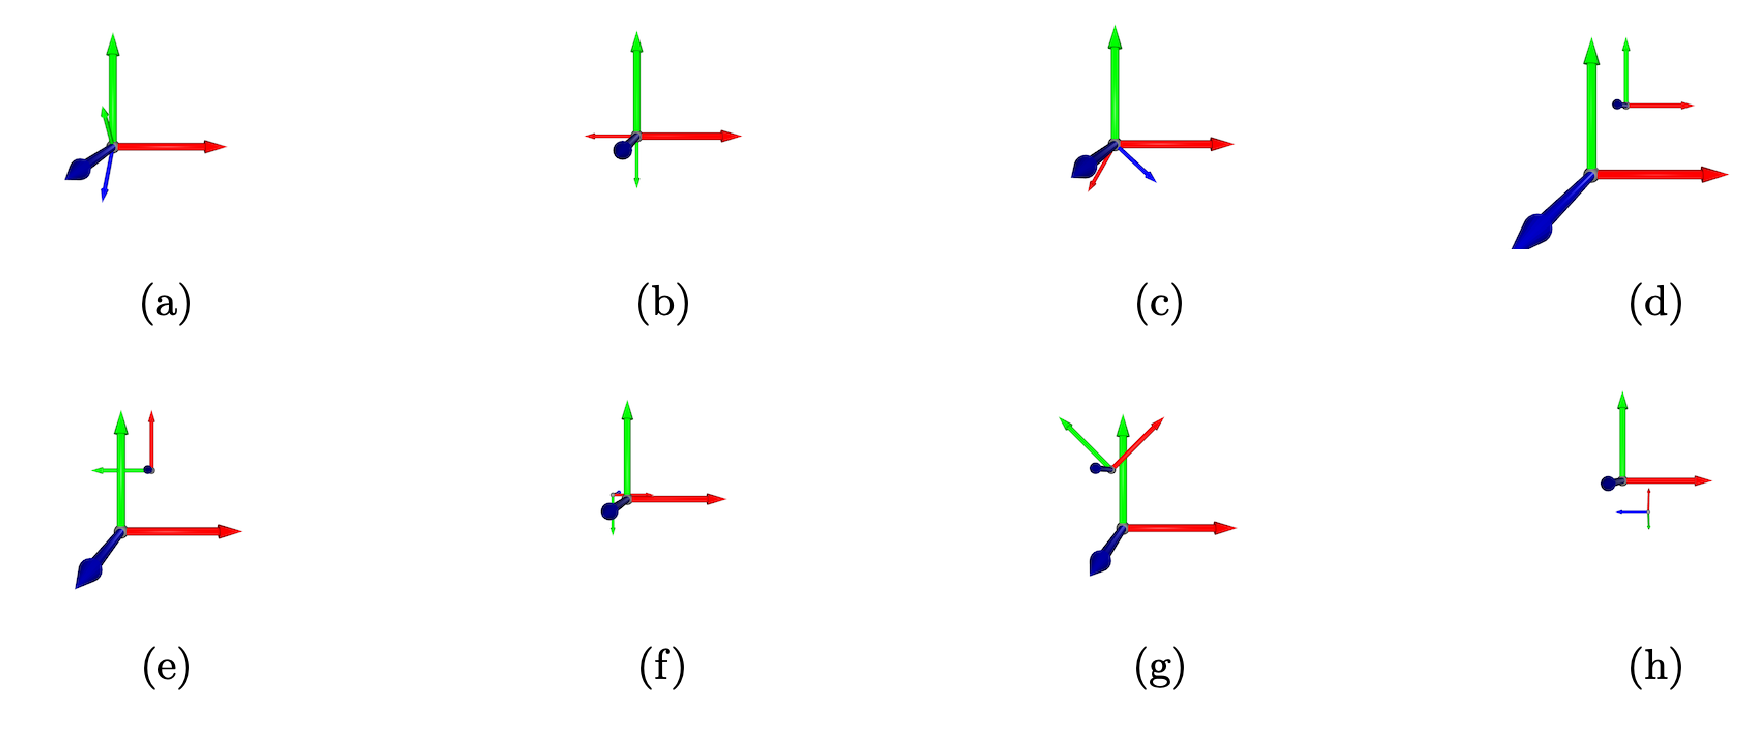

In [36]:
def T_BS_part_a() -> np.ndarray:
  T_BS = np.empty((4,4))
  """Set T_BS with approximate values based on the picture."""
  T_BS = np.array([
        [np.cos(np.deg2rad(0)), np.cos(np.deg2rad(90)), np.cos(np.deg2rad(90)), 0],
        [np.cos(np.deg2rad(90)), np.cos(np.deg2rad(45)), np.cos(np.deg2rad(135)), 0],
        [np.cos(np.deg2rad(90)), np.cos(np.deg2rad(45)), np.cos(np.deg2rad(45)), 0],
        [0, 0, 0, 1]
    ], dtype=float)
  # raise NotImplementedError
  return T_BS

def T_BS_part_b() -> np.ndarray:
  T_BS = np.empty((4,4))
  """Set T_BS with approximate values based on the picture."""
  T_BS = np.array([
    [np.cos(np.deg2rad(180)), np.cos(np.deg2rad(90)), np.cos(np.deg2rad(90)), 0],
    [np.cos(np.deg2rad(90)), np.cos(np.deg2rad(180)), np.cos(np.deg2rad(90)), 0],
    [np.cos(np.deg2rad(90)), np.cos(np.deg2rad(90)), np.cos(np.deg2rad(0)), 0],
    [0, 0, 0, 1]
    ], dtype=float)
  
  # raise NotImplementedError

  return T_BS

def T_BS_part_c() -> np.ndarray:
  T_BS = np.empty((4,4))
  """Set T_BS with approximate values based on the picture."""
  T_BS = np.array([
    [np.cos(np.deg2rad(120)), np.cos(np.deg2rad(60)), np.cos(np.deg2rad(45)), 0],
    [np.cos(np.deg2rad(150)), np.cos(np.deg2rad(95)), np.cos(np.deg2rad(120)), 0],
    [np.cos(np.deg2rad(95)), np.cos(np.deg2rad(150)), np.cos(np.deg2rad(60)), 0],
    [0, 0, 0, 1]
    ], dtype=float)
  
  # raise NotImplementedError

  return T_BS

def T_BS_part_d() -> np.ndarray:
  T_BS = np.empty((4,4))
  """Set T_BS with approximate values based on the picture."""
  T_BS = np.array([
    [np.cos(np.deg2rad(0)), np.cos(np.deg2rad(90)), np.cos(np.deg2rad(90)), 0.5],
    [np.cos(np.deg2rad(90)), np.cos(np.deg2rad(0)), np.cos(np.deg2rad(90)), 1],
    [np.cos(np.deg2rad(90)), np.cos(np.deg2rad(90)), np.cos(np.deg2rad(0)), 0],
    [0, 0, 0, 1]
    ], dtype=float)
  
  # raise NotImplementedError

  return T_BS

def T_BS_part_e() -> np.ndarray:
  T_BS = np.empty((4,4))
  """Set T_BS with approximate values based on the picture."""
  T_BS = np.array([
    [np.cos(np.deg2rad(90)), np.cos(np.deg2rad(180)), np.cos(np.deg2rad(90)), 0.5],
    [np.cos(np.deg2rad(0)), np.cos(np.deg2rad(90)), np.cos(np.deg2rad(90)), 1],
    [np.cos(np.deg2rad(90)), np.cos(np.deg2rad(90)), np.cos(np.deg2rad(0)), 0],
    [0, 0, 0, 1]
    ], dtype=float)
  
  # raise NotImplementedError

  return T_BS

def T_BS_part_f() -> np.ndarray:
  T_BS = np.empty((4,4))
  """Set T_BS with approximate values based on the picture."""
  T_BS = np.array([
    [np.cos(np.deg2rad(0)), np.cos(np.deg2rad(90)), np.cos(np.deg2rad(90)), -0.5],
    [np.cos(np.deg2rad(90)), np.cos(np.deg2rad(180)), np.cos(np.deg2rad(90)), 0],
    [np.cos(np.deg2rad(90)), np.cos(np.deg2rad(90)), np.cos(np.deg2rad(180)), -1],
    [0, 0, 0, 1]
    ], dtype=float)
  
  # raise NotImplementedError

  return T_BS

def T_BS_part_g() -> np.ndarray:
  T_BS = np.empty((4,4))
  """Set T_BS with approximate values based on the picture."""
  T_BS = np.array([
    [np.cos(np.deg2rad(45)), np.cos(np.deg2rad(135)), np.cos(np.deg2rad(90)), 0],
    [np.cos(np.deg2rad(45)), np.cos(np.deg2rad(45)), np.cos(np.deg2rad(90)), 1],
    [np.cos(np.deg2rad(90)), np.cos(np.deg2rad(90)), np.cos(np.deg2rad(0)), 1],
    [0, 0, 0, 1]
    ], dtype=float)
  
  # raise NotImplementedError

  return T_BS

def T_BS_part_h() -> np.ndarray:
  T_BS = np.empty((4,4))
  """Set T_BS with approximate values based on the picture."""
  T_BS = np.array([
    [np.cos(np.deg2rad(90)), np.cos(np.deg2rad(90)), np.cos(np.deg2rad(180)), 0.5],
    [np.cos(np.deg2rad(45)), np.cos(np.deg2rad(135)), np.cos(np.deg2rad(90)), -1],
    [np.cos(np.deg2rad(135)), np.cos(np.deg2rad(135)), np.cos(np.deg2rad(90)), -2],
    [0, 0, 0, 1]
    ], dtype=float)
  # raise NotImplementedError

  return T_BS

# Problem 3: Object pose estimation

A 3D object $O$ has feature points at the following locations, expressed in the object's body-centric coordinate frame: ${}_O p_1, {}_O p_2, {}_O p_3, {}_O p_4 \in \mathbb{R}^3$.

Using a stereo camera (or 3D lidar), a robot observes this object, and measures the locations of these feature points as ${}_S p_1, {}_S p_2, {}_S p_3, {}_S p_4 \in \mathbb{R}^3$ in the stereo camera's body-centric frame $S$.

What is the pose $T_{SO} \in SE(3)$ of object $O$ with respect to the camera frame $S$? In this problem, you will write a function that can compute this pose, assuming the given points have properties that make this possible.

**Deliverables**:
- Implement `estimate_pose_from_feature_pts` to return $T_{SO} \in SE(3)$ as a np.array of size (4,4)
- Write a 1-2 sentence description of what property(ies) the given points need to have that make solving for this pose possible.

In [27]:
def estimate_pose_from_feature_pts(
    op1: np.ndarray,
    op2: np.ndarray,
    op3: np.ndarray,
    op4: np.ndarray,
    sp1: np.ndarray,
    sp2: np.ndarray,
    sp3: np.ndarray,
    sp4: np.ndarray
) -> np.ndarray:

  """T_SO should be a 4x4 np array computed using the pts in O and S."""
  T_SO = np.eye(4)
  OP = np.vstack([op1, op2, op3, op4])
  OC = np.mean(OP, axis=0)
  SP = np.vstack([sp1, sp2, sp3, sp4])
  SC = np.mean(SP, axis=0)
  vec_O = OP - OC
  vec_S = SP - SC

  H = vec_S.T @ vec_O # Covariance matrix
  U, _, V = np.linalg.svd(H)
  R = U @ V
  T = SC - R @ OC
  T_SO[:3, :3] = R
  T_SO[:3, 3] = T

  # if np.linalg.det(R) < 0:
  #   U[:, -1] *= -1
  #   R = U @ V
  
  # raise NotImplementedError
  
  return T_SO

You can debug your code with the following example points (we'll use different points to check your implementation):

In [28]:
# Feature pts in O
op1 = np.array([2, 3, -3])
op2 = np.array([0, 0, -3])
op3 = np.array([-1, -2, 2])
op4 = np.array([-1, 0, 2])

# Feature pts in S
sp1 = np.array([1.8641, 3.0182, -0.5214])
sp2 = np.array([-0.0960, -0.0064, -0.4255])
sp3 = np.array([-0.0827, -2.5055, 4.4484])
sp4 = np.array([-0.0827, -0.5155, 4.6480])

T_SO = estimate_pose_from_feature_pts(op1, op2, op3, op4, sp1, sp2, sp3, sp4)
print(T_SO)

# Check that the estimate of sp1 by transforming op1 is the same as the true sp1
sp1_estimated = T_SO@np.hstack([op1, 1])
np.testing.assert_array_almost_equal(sp1_estimated[:3], sp1)

[[ 9.80064676e-01  3.50704477e-06  1.98678714e-01  5.00013480e-01]
 [ 1.98307267e-02  9.95004482e-01 -9.78407999e-02 -2.99971521e-01]
 [-1.97686554e-01  9.98302551e-02  9.75168676e-01  2.50000177e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


AssertionError: 
Arrays are not almost equal to 6 decimals

Mismatched elements: 3 / 3 (100%)
Max absolute difference among violations: 2.57800238e-05
Max relative difference among violations: 2.57078027e-05
 ACTUAL: array([ 1.864117,  3.018226, -0.521387])
 DESIRED: array([ 1.8641,  3.0182, -0.5214])

Properties:  
 - The four feature points should not be collinear. At a minimum, 3 non-collinear points are needed to uniquely determine a rigid-body transformation in 3D.

# Problem 4: Matrix Groups

The following questions will cover some properties of different matrix groups under matrix multiplication. You should fill in each function to return a list of all properties from the Properties class that apply to elements of that group (e.g., `return [Properties.SYMMETRIC, Properties.ORTHONORMAL]`). You can leverage the compositional properties of the groups to make the coding easier (e.g., for `SO2`, `return O2()+[...]`).

In [2]:
from enum import Enum

In [3]:
class Properties(Enum):
  INVERTIBLE = 1
  SQUARE = 2
  ORIENTATION_PRESERVING = 3
  DETERMINANT_EQUALS_1 = 4
  DIMENSION_2x2 = 5
  DIMENSION_3x3 = 6
  DIMENSION_4x4 = 7
  DIMENSION_3x4 = 8
  DIMENSION_2x3 = 9
  SYMMETRIC = 10
  ORTHONORMAL = 11
  DISTANCE_PRESERVING = 12
  INNER_PRODUCT_PRESERVING = 13
  BOTTOM_RIGHT_ELEMENT_EQUALS_1 = 14
  INVERSE_EQUALS_TRANSPOSE = 15
  ROTATION = 16
  RIGID_MOTION = 17

def GL2():
  return [Properties.INVERTIBLE, Properties.SQUARE, Properties.DIMENSION_2x2]

def GL3():
  return [Properties.INVERTIBLE, Properties.SQUARE, Properties.DIMENSION_3x3]

def Aff2():
  return [Properties.INVERTIBLE, Properties.SQUARE, Properties.DIMENSION_3x3, Properties.BOTTOM_RIGHT_ELEMENT_EQUALS_1]

def Aff3():
  return [Properties.INVERTIBLE, Properties.SQUARE, Properties.DIMENSION_4x4, Properties.BOTTOM_RIGHT_ELEMENT_EQUALS_1]

def O2():
  return [Properties.INVERTIBLE, Properties.SQUARE, Properties.DIMENSION_2x2, Properties.ORTHONORMAL, 
          Properties.DISTANCE_PRESERVING, Properties.INNER_PRODUCT_PRESERVING, Properties.INVERSE_EQUALS_TRANSPOSE]

def O3():
  return [Properties.INVERTIBLE, Properties.SQUARE, Properties.DIMENSION_3x3, Properties.ORTHONORMAL, 
          Properties.DISTANCE_PRESERVING, Properties.INNER_PRODUCT_PRESERVING, Properties.INVERSE_EQUALS_TRANSPOSE]

def E2():
  return [Properties.INVERTIBLE, Properties.SQUARE, Properties.DIMENSION_3x3, 
          Properties.DISTANCE_PRESERVING, Properties.BOTTOM_RIGHT_ELEMENT_EQUALS_1]

def E3():
  return [Properties.INVERTIBLE, Properties.SQUARE, Properties.DIMENSION_4x4, 
          Properties.DISTANCE_PRESERVING, Properties.BOTTOM_RIGHT_ELEMENT_EQUALS_1]

def SO2():
  return [Properties.INVERTIBLE, Properties.SQUARE, Properties.ORIENTATION_PRESERVING, Properties.DETERMINANT_EQUALS_1, Properties.DIMENSION_2x2,
          Properties.ORTHONORMAL, Properties.DISTANCE_PRESERVING, Properties.INNER_PRODUCT_PRESERVING, Properties.INVERSE_EQUALS_TRANSPOSE, Properties.ROTATION]

def SO3():
  return [Properties.INVERTIBLE, Properties.SQUARE, Properties.ORIENTATION_PRESERVING, Properties.DETERMINANT_EQUALS_1, Properties.DIMENSION_3x3,
          Properties.ORTHONORMAL, Properties.DISTANCE_PRESERVING, Properties.INNER_PRODUCT_PRESERVING, Properties.INVERSE_EQUALS_TRANSPOSE, Properties.ROTATION]

def SE2():
  return [Properties.INVERTIBLE, Properties.SQUARE, Properties.ORIENTATION_PRESERVING, Properties.DIMENSION_3x3, Properties.DETERMINANT_EQUALS_1,
          Properties.DISTANCE_PRESERVING, Properties.BOTTOM_RIGHT_ELEMENT_EQUALS_1, Properties.RIGID_MOTION]

def SE3():
  return [Properties.INVERTIBLE, Properties.SQUARE, Properties.ORIENTATION_PRESERVING, Properties.DIMENSION_4x4, Properties.DETERMINANT_EQUALS_1,
          Properties.DISTANCE_PRESERVING, Properties.BOTTOM_RIGHT_ELEMENT_EQUALS_1, Properties.RIGID_MOTION]